# Итог

In [ ]:
from bs4 import BeautifulSoup
import requests
import json
from datetime import datetime
import re
import pandas as pd
results = []
tag_re = re.compile(r'(<!--.*?-->|<[^>]*>)')
max_pages = 10
home_url = 'https://www.mcgeeandco.com/'
home_html_text = requests.get(home_url).text
root = 'https://www.mcgeeandco.com'
home_soup = BeautifulSoup(home_html_text, 'lxml')
menu = home_soup.find('div', class_ = 'scrolling')
all_links = [link['href'] for link in menu.find_all('a', href=True)]
for x in all_links:
    if x == '#':
        continue
    elif x[1] == 'p':
        continue
    elif x[0:16] == '/collections/all':
        continue
    else:
        subcategories_url = root + x +'?page='
        for p in range(max_pages):
            cur_url = subcategories_url + str(p + 1)
            subcategories_html_text = requests.get(cur_url).text
            subcategories_soup = BeautifulSoup(subcategories_html_text, 'lxml')
            catalog = subcategories_soup.find('div', class_ = 'container py-xxs-2 pt-sm-4 pb-sm-8')
            class_category = subcategories_soup.find('div', class_ = 'scrolling').find('li', class_ = 'nav-top-level active nav-single-col')
            if class_category is None:
                class_category = subcategories_soup.find('div', class_ = 'scrolling').find('li', class_ = 'nav-top-level active')
            category = class_category.find(class_ = 'nav-trigger').text.strip()
            subcategory = catalog.find('div', class_ = 'cl-xxs-5')
            if subcategory is None:
                subcategory = 'The Upholstery Collection' 
            else:
                subcategory = subcategories_soup.find('div', class_ = 'cl-xxs-5').text
            links = [link1['href'] for link1 in catalog.find_all('a', href=True)]
            for each in links:
                if each[1] == 'c':
                    break
                else:
                    product_url = root + each
                    product_html_text = requests.get(product_url).text
                    product_soup = BeautifulSoup(product_html_text, 'lxml')
                    product_information = product_soup.find('div', class_ = 'buy-wrapper')
                    if product_information is None:
                        answer = 'No'
                    else:
                        add_to_cart = product_information.find(class_ = 'btn btn-shop inactive')
                        if add_to_cart is None:
                            answer = 'Yes'
                        else:
                            button_active = add_to_cart.find('span').text
                            if button_active == 'Add to Cart':
                                answer = 'Possible to order'
                            else:
                                answer = 'No'
                    page_info = json.loads(product_soup.find('script', class_ = 'js-product-json').text)
                    if page_info is None:
                        continue
                    else:
                        product_info = page_info['product']
                        name = product_info['title']
                        description = tag_re.sub('', product_soup.find('div', class_ = 'description pb-xxs-2 f3').text.strip())
                        price = product_info['price']/100
                        created_at = datetime.fromisoformat(product_info['created_at'])
                        subcategory_name = subcategory.strip()
                        results.append({
                        'name': name,
                        'category': category,
                        'subcategory': subcategory_name,
                        'price': price,
                        'created_at': created_at,
                        'purchase_opportunity': answer,
                        'description': description                 
                        })
            print(cur_url)
frame = pd.DataFrame(results)


In [ ]:
filename = 'File_scraper.csv'
frame.to_csv(filename)

In [1]:
import pandas as pd
dataset = pd.read_csv("C:/Users/Dell/Downloads/python/scraping/File_scraper.csv", encoding = 'utf-8', sep = ',')
dataset.head()

,Unnamed: 0,name,category,subcategory,price,created_at,purchase_opportunity,description
0,0,Elowyn Outdoor Chair,New Arrivals,New Outdoor,1800.0,2020-10-20 09:30:32-06:00,Yes,"Designed with high-quality teak wood, Sunbrell..."
1,1,Triby Outdoor Chair,New Arrivals,New Outdoor,850.0,2020-09-09 11:00:04-06:00,Yes,"With both durability and beauty in mind, we de..."
2,2,Goodwin Wicker Dining Chair,New Arrivals,New Outdoor,750.0,2021-11-23 16:53:19-07:00,Yes,"Crafted from all-weather polywicker, the Goodw..."
3,3,Vento Outdoor Sofa,New Arrivals,New Outdoor,2200.0,2021-07-16 13:41:46-06:00,Yes,"Bringing indoor elements to outdoor furniture,..."
4,4,Berdine Wicker Outdoor Sofa,New Arrivals,New Outdoor,3600.0,2019-10-23 09:56:15-06:00,Yes,Streamlined and sophisticated with an added co...


In [2]:
print(dataset.shape)

(5193, 8)


In [3]:
print(dataset.describe())

        Unnamed: 0         price
count  5193.000000   5193.000000
mean   2596.000000    978.453765
std    1499.234305   1506.285106
min       0.000000      3.990000
25%    1298.000000    102.000000
50%    2596.000000    450.000000
75%    3894.000000   1150.000000
max    5192.000000  14560.000000


In [4]:
print(dataset.groupby('category').size())

category
Artwork & Mirrors     700
Bed & Bath            208
Furniture            1181
Kids                   89
Kitchen               306
Lighting              627
New Arrivals          507
Outdoor               273
Pillows & Decor       643
Rugs                  427
Sale                   99
Vintage               133
dtype: int64


In [5]:
print(dataset.groupby('purchase_opportunity').size())

purchase_opportunity
No                    282
Possible to order     419
Yes                  4492
dtype: int64


In [6]:
print(dataset.groupby('subcategory').size())

subcategory
Abstract Art            131
All Home Office          99
All Wallpaper            44
Bar & Counter Stools     61
Baskets & Bins           32
                       ... 
Vintage Decor            74
Vintage Furniture        37
Vintage Kitchen          16
Vintage Rugs             66
Wool Rugs                60
Length: 126, dtype: int64


In [11]:
!pip install -U pandasql

  Using cached pandasql-0.7.3-py3-none-any.whl


Text(0, 0.5, 'Count')

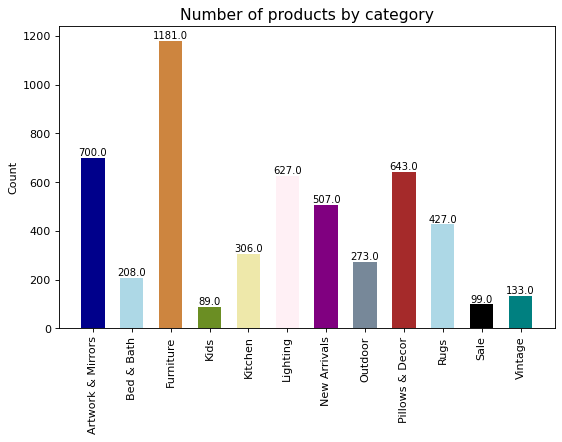

In [12]:
import pandasql as ps
from matplotlib import pyplot as plt
import random
df = dataset.groupby('category').size().reset_index(name='counts')
n = df['category'].unique().__len__()+1
all_colors = list(plt.cm.colors.cnames.keys())
random.seed(100)
c = random.choices(all_colors, k=n)
plt.figure(figsize=(8,5), dpi= 80)
plt.bar(df['category'], df['counts'], color = c, width=.6)
#dataset.groupby('category').size().plot()
plt.xticks(rotation = 90)
for i, val in enumerate(df['counts'].values):
    plt.text(i, val, float(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'size':9})
plt.title("Number of products by category", fontsize=14)
plt.ylabel('Count')

Text(0, 0.5, 'Count')

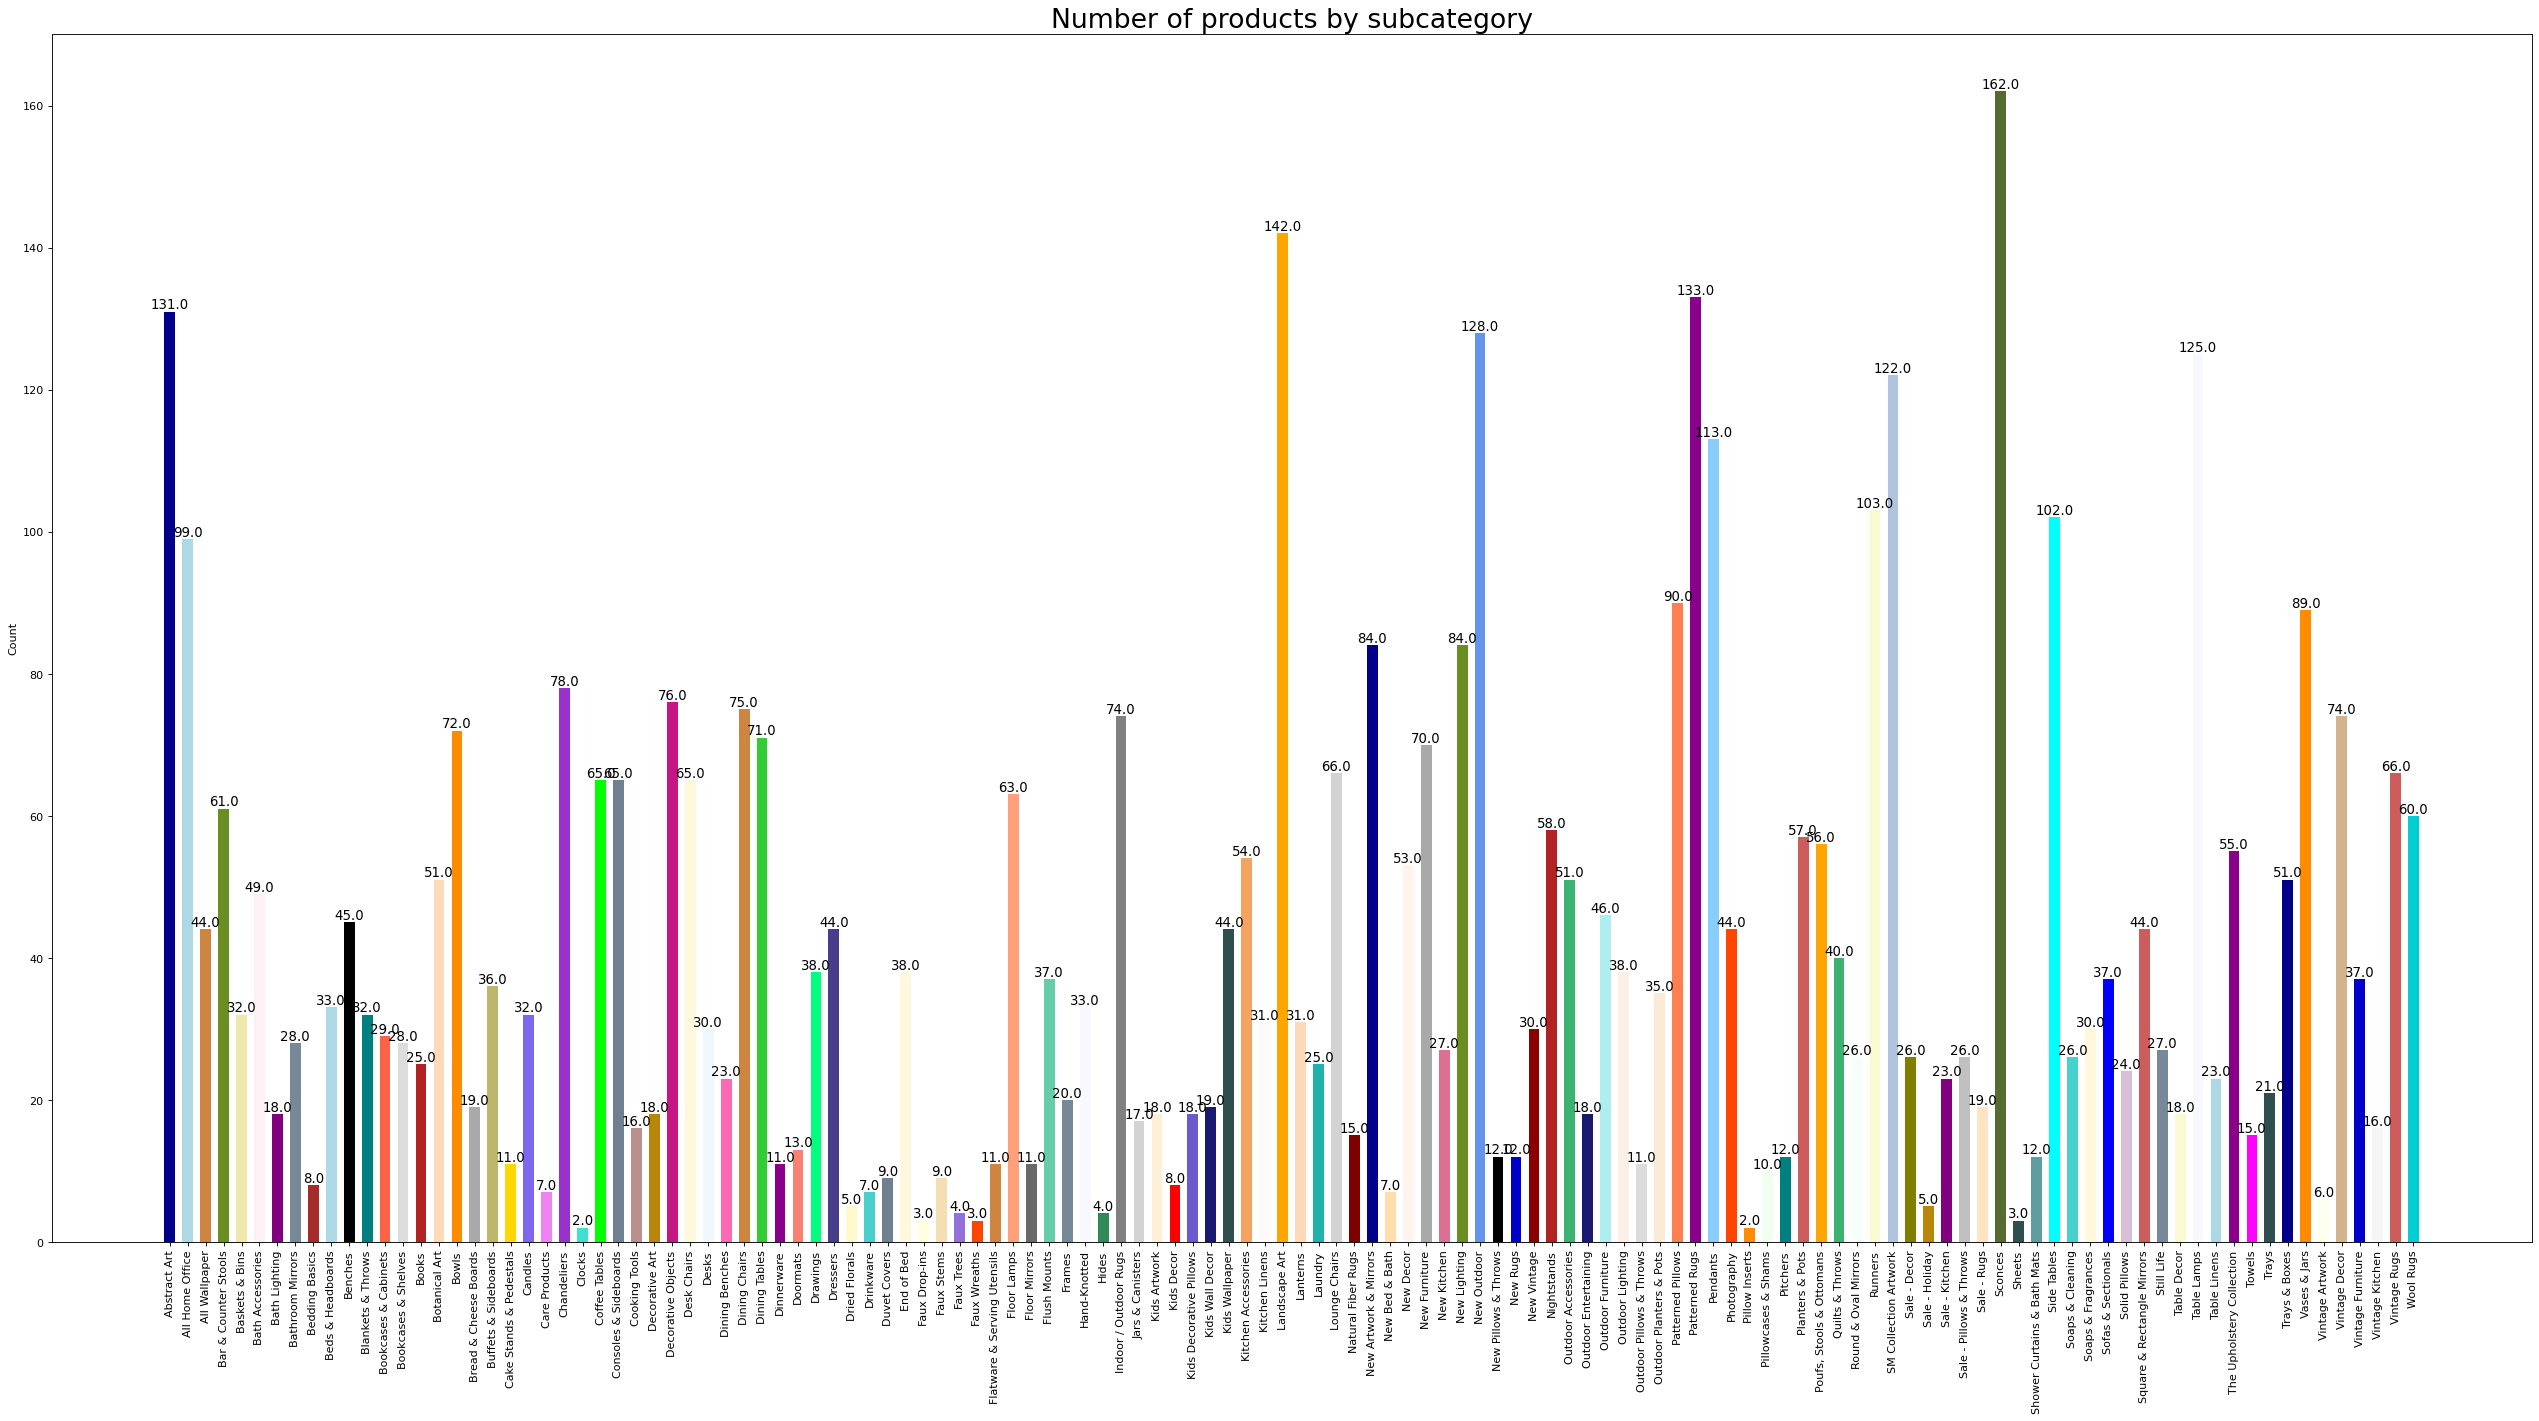

In [13]:
import random
df = dataset.groupby('subcategory').size().reset_index(name='counts')
n = df['subcategory'].unique().__len__()+1
all_colors = list(plt.cm.colors.cnames.keys())
random.seed(100)
c = random.choices(all_colors, k=n)
plt.figure(figsize=(40,20), dpi= 80)
plt.bar(df['subcategory'], df['counts'], color = c, width=.6)
#dataset.groupby('category').size().plot()
plt.xticks(rotation = 90)
for i, val in enumerate(df['counts'].values):
    plt.text(i, val, float(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'size':12})
plt.title("Number of products by subcategory", fontsize=24)
plt.ylabel('Count')

Text(0.5, 0, 'category')

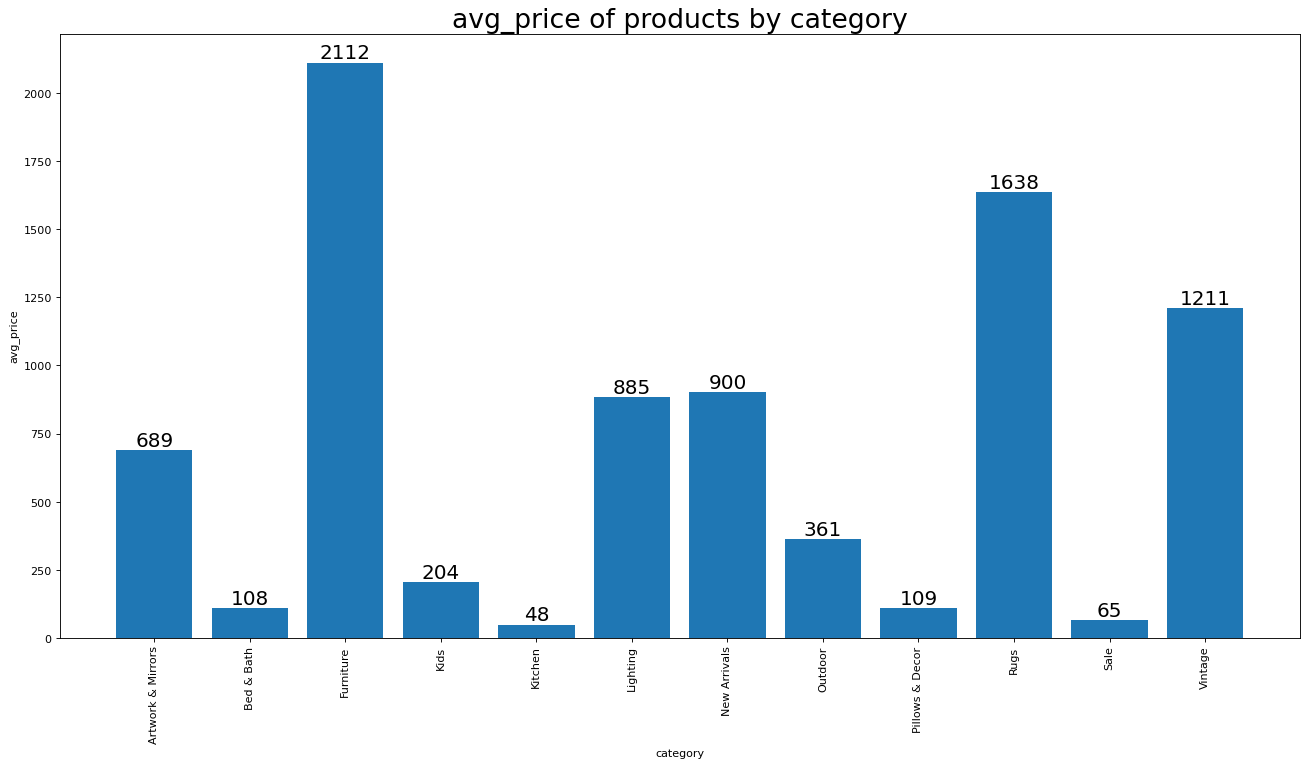

In [16]:
import pandasql as ps
import matplotlib
from matplotlib import pyplot as plt
category_avg_price = ps.sqldf("select distinct category, avg(price) over (partition by category) from dataset")
category =  category_avg_price["category"]
avg_price_category = category_avg_price["avg(price) over (partition by category)"]
plt.figure(figsize=(20,10), dpi= 80)
matplotlib.pyplot.bar(category, avg_price_category)
matplotlib.pyplot.xticks(rotation = 90)
for i, val in enumerate(avg_price_category.values):
    plt.text(i, val, int(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'size':18})
plt.title("avg_price of products by category", fontsize=24)
plt.ylabel('avg_price')
plt.xlabel('category')

Text(0.5, 0, 'subcategory')

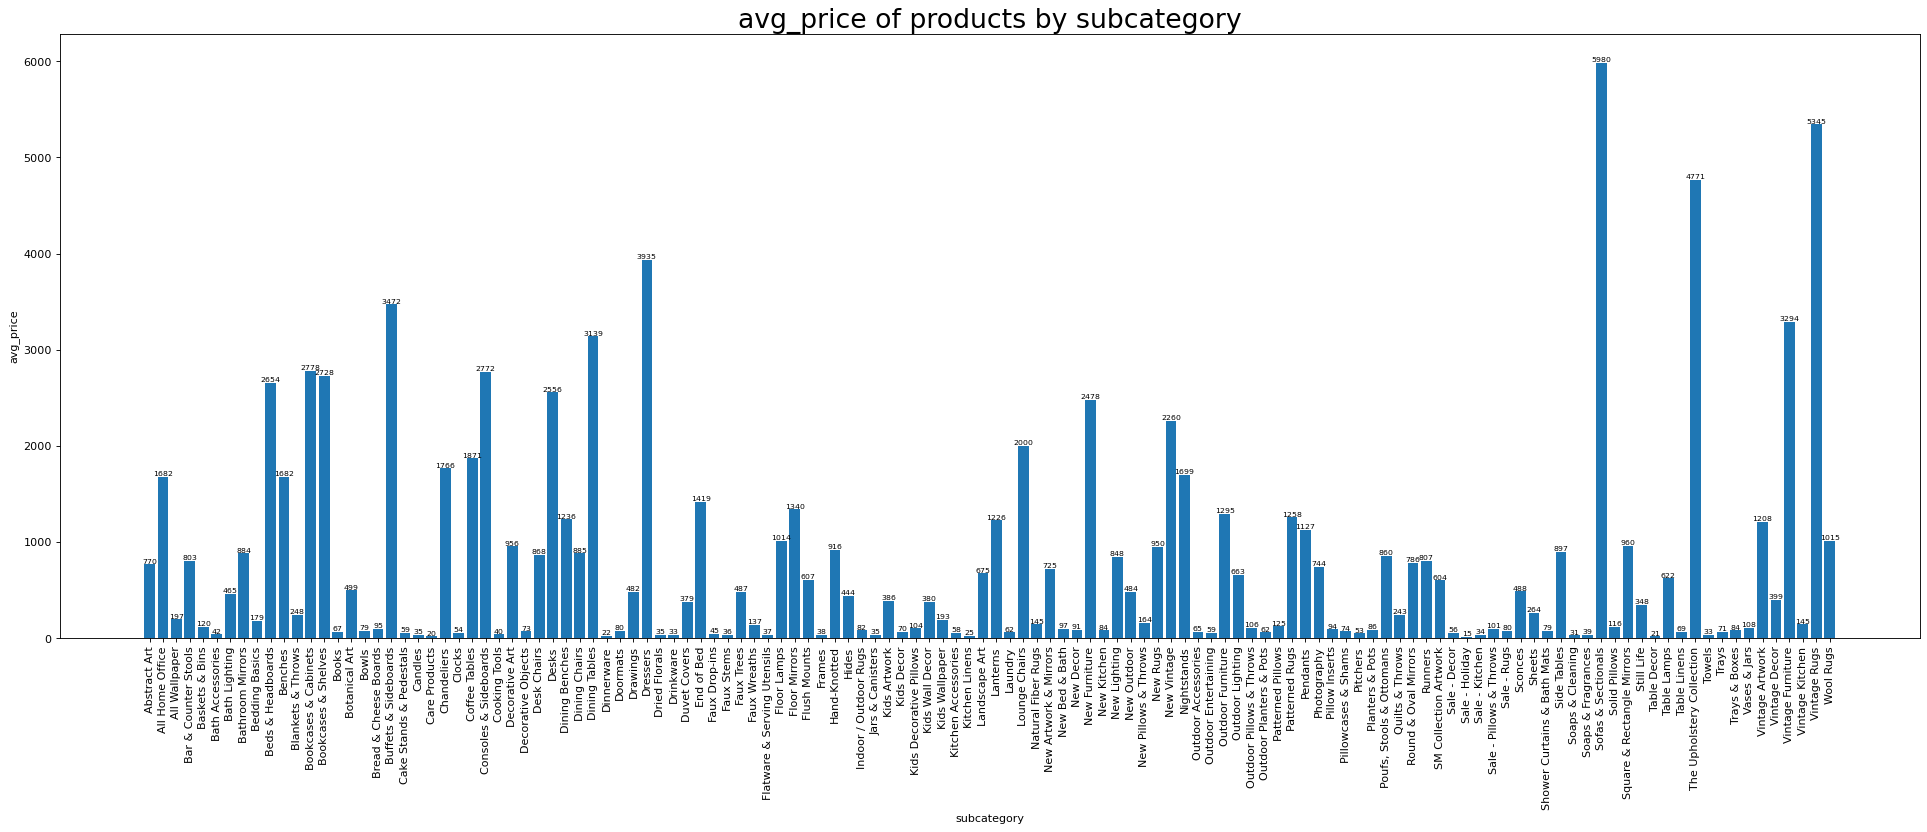

In [17]:
subcategory_avg_price = ps.sqldf("select distinct subcategory, avg(price) over (partition by subcategory) from dataset")
subcategory =  subcategory_avg_price["subcategory"]
avg_price_subcategory = subcategory_avg_price["avg(price) over (partition by subcategory)"]
plt.figure(figsize=(30,10), dpi= 80)
matplotlib.pyplot.bar(subcategory, avg_price_subcategory)
matplotlib.pyplot.xticks(rotation = 90)
for i, val in enumerate(avg_price_subcategory.values):
    plt.text(i, val, int(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'size':7})
plt.title("avg_price of products by subcategory", fontsize=24)
plt.ylabel('avg_price')
plt.xlabel('subcategory')

Text(0.5, 0, 'category')

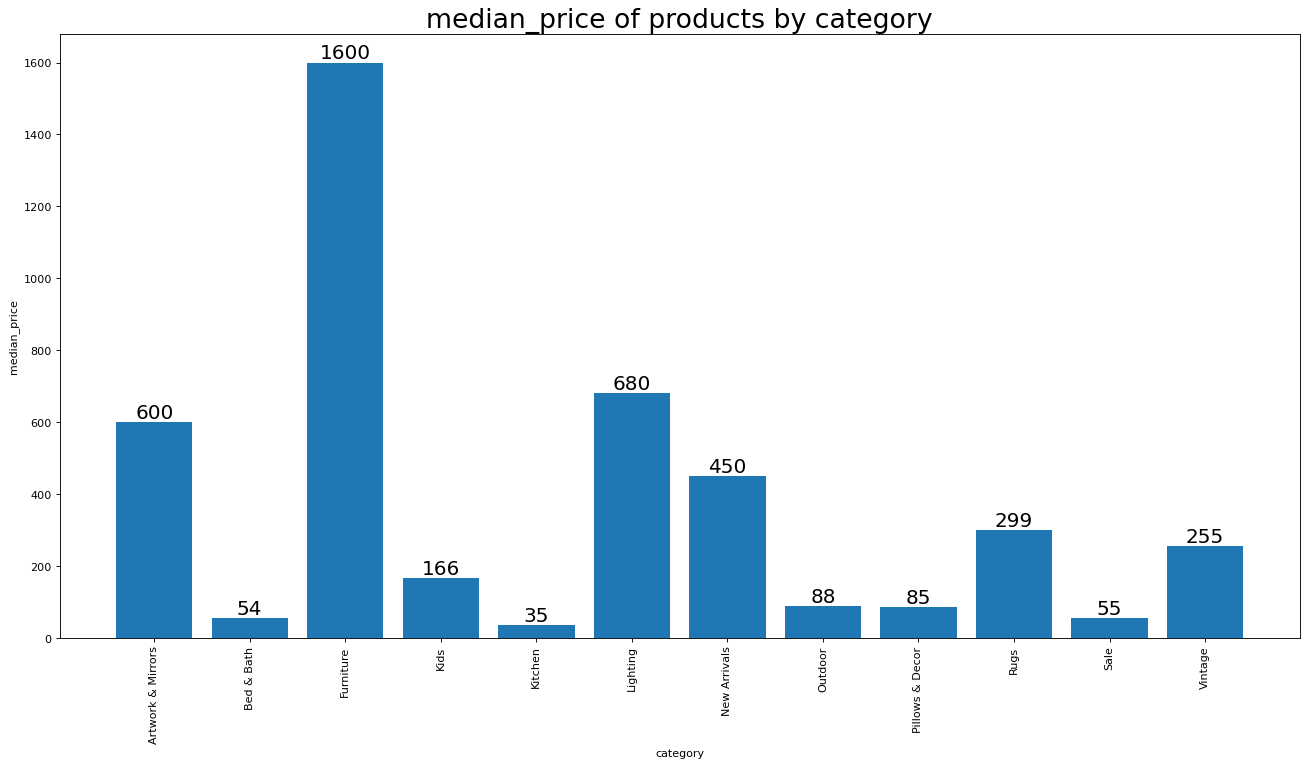

In [18]:
category_median_price = ps.sqldf("select e.category, e.price from (select v.category, v.price, row_number() over (partition by v.category order by price) row_number, count_rows from dataset v left join (select r.category, r.count_/2 count_rows from (select d.category, count(*) as count_ from (select category, price, row_number() over (partition by category order by price) row_number from dataset) d group by category) r) q on v.category = q.category) e where row_number = count_rows")
category_median =  category_median_price["category"]
median_price_category = category_median_price["price"]
plt.figure(figsize=(20,10), dpi= 80)
matplotlib.pyplot.bar(category_median, median_price_category)
matplotlib.pyplot.xticks(rotation = 90)
for i, val in enumerate(median_price_category.values):
    plt.text(i, val, int(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'size':18})
plt.title("median_price of products by category", fontsize=24)
plt.ylabel('median_price')
plt.xlabel('category')

Text(0.5, 0, 'subcategory')

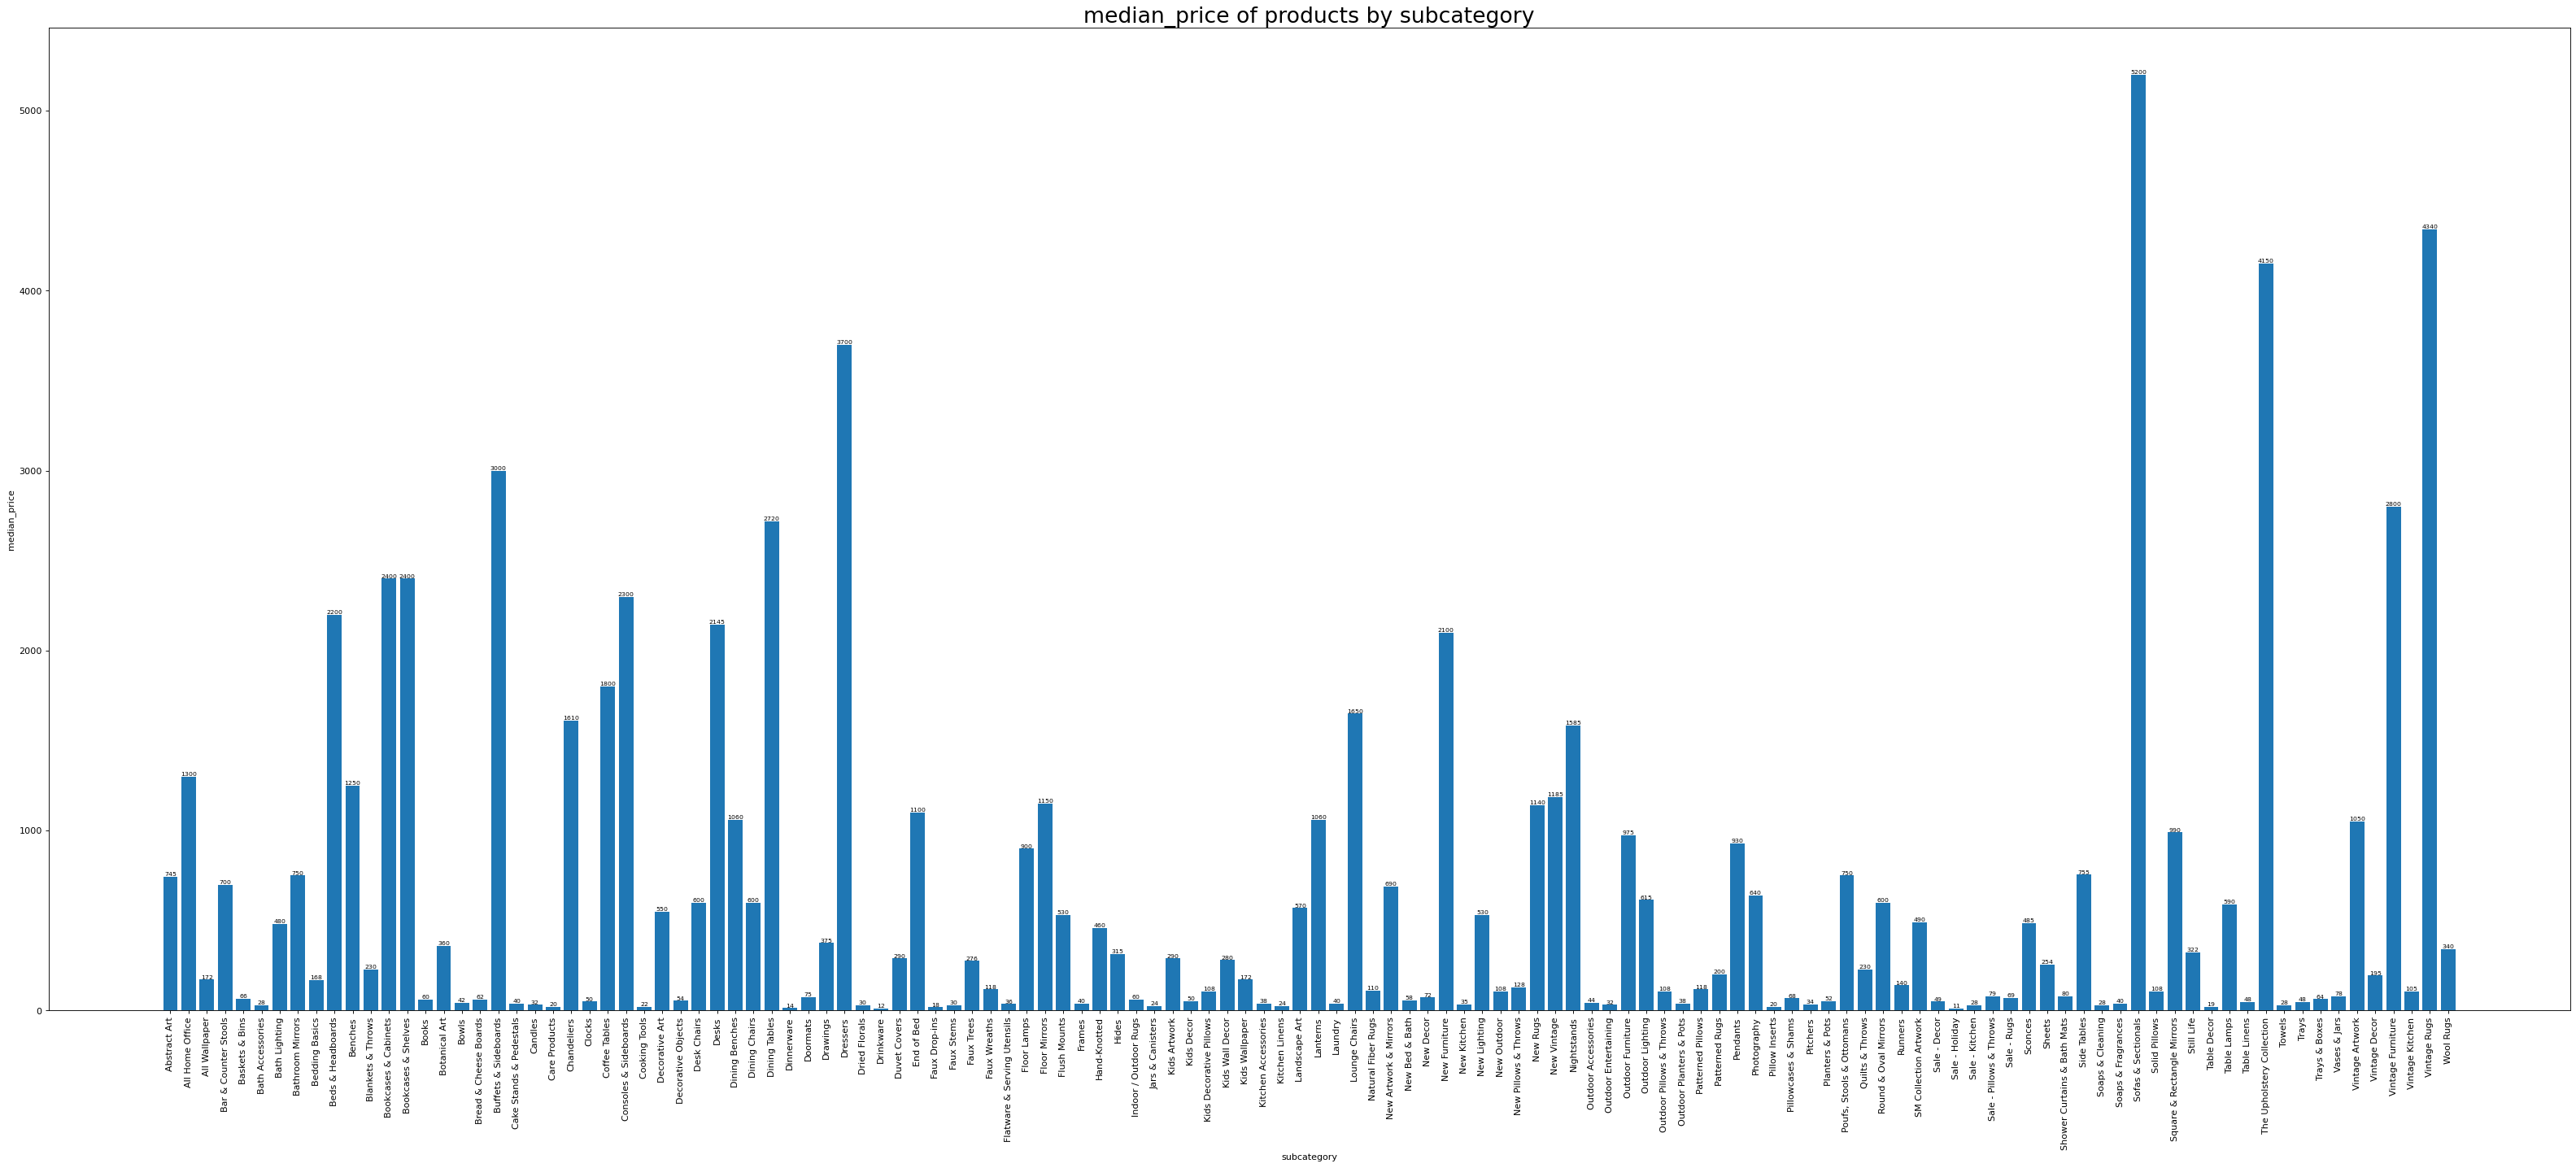

In [19]:
subcategory_median_price = ps.sqldf("select e.subcategory, e.price from (select v.subcategory, v.price, row_number() over (partition by v.subcategory order by price) row_number, count_rows from dataset v left join (select r.subcategory, r.count_/2 count_rows from (select d.subcategory, count(*) as count_ from (select subcategory, price, row_number() over (partition by subcategory order by price) row_number from dataset) d group by subcategory) r) q on v.subcategory = q.subcategory) e where row_number = count_rows")
subcategory_median =  subcategory_median_price["subcategory"]
median_price_subcategory = subcategory_median_price["price"]
plt.figure(figsize=(50,20), dpi= 80)
matplotlib.pyplot.bar(subcategory_median, median_price_subcategory)
matplotlib.pyplot.xticks(rotation = 90)
for i, val in enumerate(median_price_subcategory.values):
    plt.text(i, val, int(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'size':7})
plt.title("median_price of products by subcategory", fontsize=24)
plt.ylabel('median_price')
plt.xlabel('subcategory')

Text(0.5, 0, 'category')

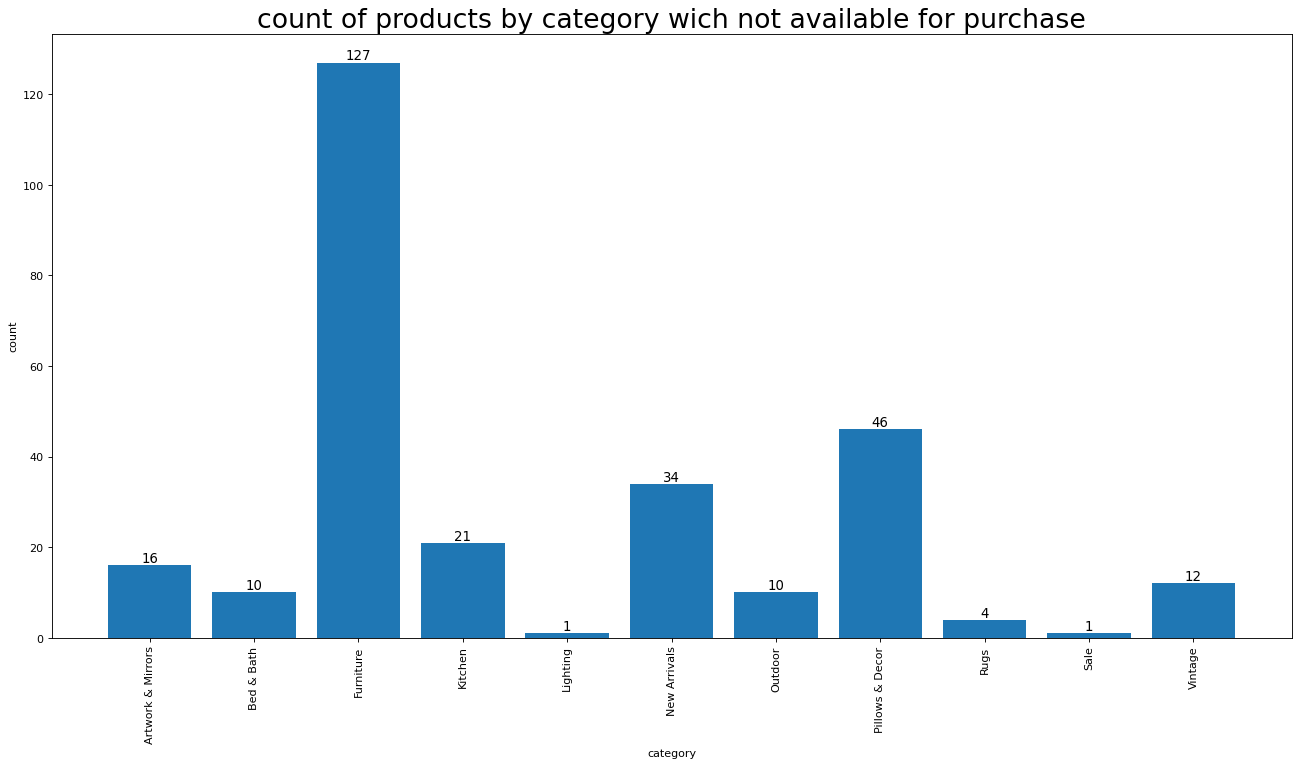

In [20]:
no_purchase_category = ps.sqldf("select category, count(*) count from dataset where purchase_opportunity = 'No' group by category")
category_purchase =  no_purchase_category["category"]
count_category = no_purchase_category["count"]
plt.figure(figsize=(20,10), dpi= 80)
matplotlib.pyplot.bar(category_purchase, count_category)
matplotlib.pyplot.xticks(rotation = 90)
for i, val in enumerate(count_category.values):
    plt.text(i, val, int(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'size':12})
plt.title("count of products by category wich not available for purchase", fontsize=24)
plt.ylabel('count')
plt.xlabel('category')

Text(0.5, 0, 'subcategory')

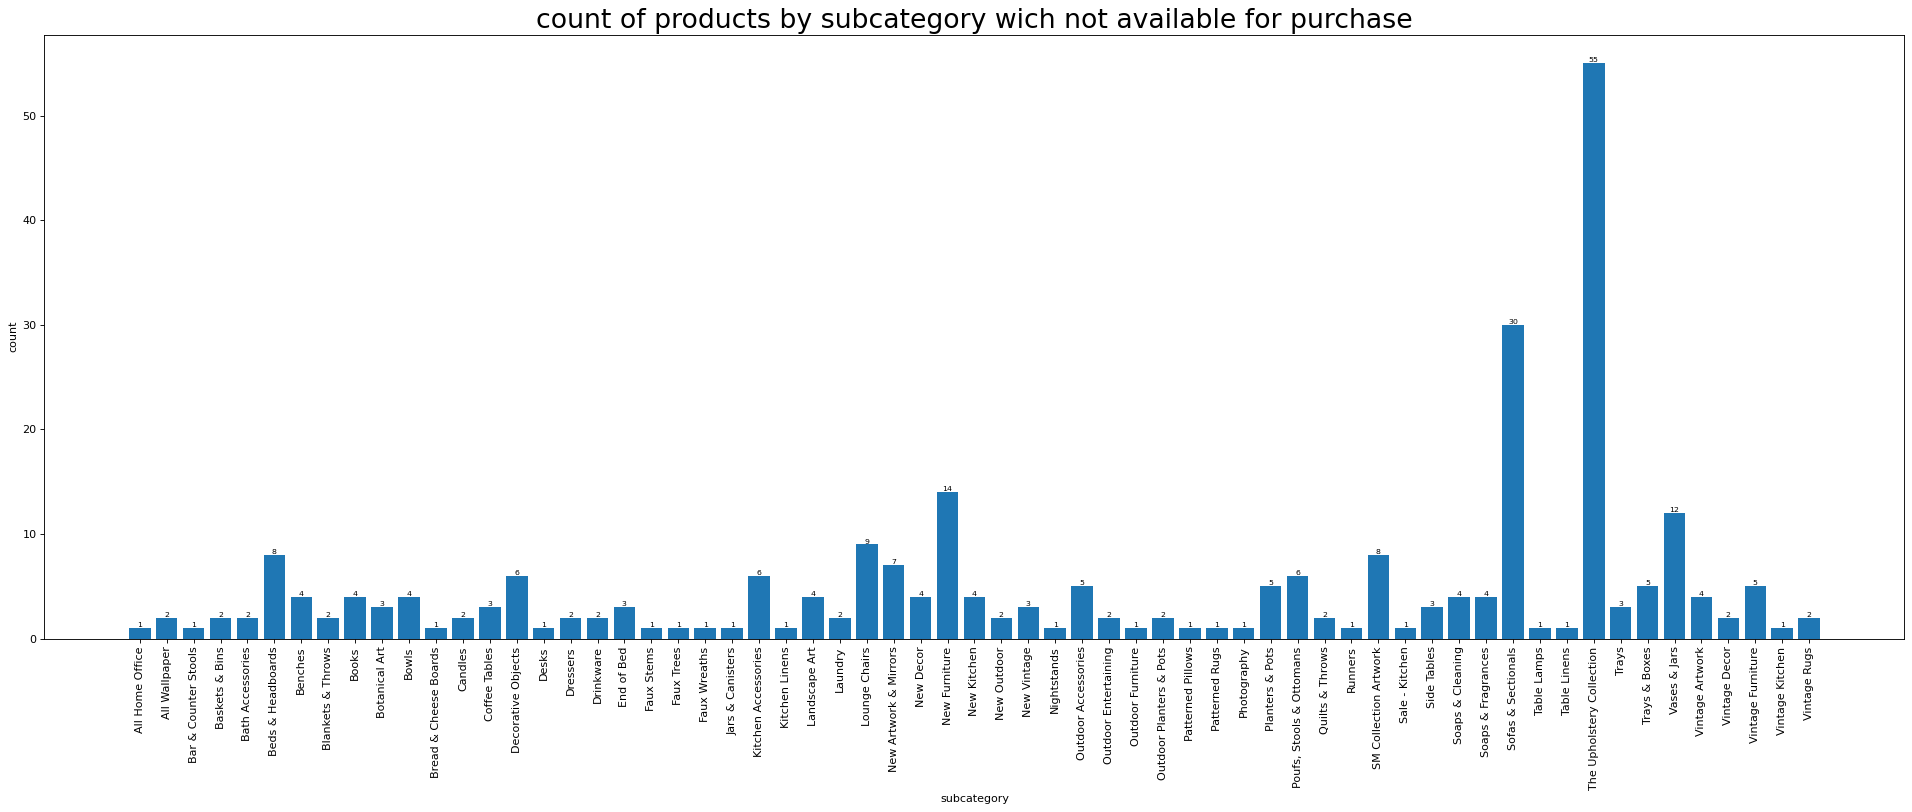

In [21]:
no_purchase_subcategory = ps.sqldf("select subcategory, count(*) count from dataset where purchase_opportunity = 'No' group by subcategory")
subcategory_purchase =  no_purchase_subcategory["subcategory"]
count_subcategory = no_purchase_subcategory["count"]
plt.figure(figsize=(30,10), dpi= 80)
matplotlib.pyplot.bar(subcategory_purchase, count_subcategory)
matplotlib.pyplot.xticks(rotation = 90)
for i, val in enumerate(count_subcategory.values):
    plt.text(i, val, int(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'size':7})
plt.title("count of products by subcategory wich not available for purchase", fontsize=24)
plt.ylabel('count')
plt.xlabel('subcategory')